# _Taxes_ library driver program

#### Technical imports

In [247]:
%load_ext autoreload
%load_ext line_profiler
%load_ext snakeviz
%load_ext memory_profiler

%autoreload 2

from taxes.download import get_sheet_links_names, download_sheet_series, get_gus_stats
from taxes.loading import dload_to_df_list
from taxes.processing import get_stats_gus
from taxes.analyze import get_med_income_gminy, get_var, get_med_income_woj, get_med_income_powiaty, get_med_income, get_med_income_miasta_NPP
from taxes.visualize import vis_woj, vis_pow, vis_NPP
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
import re
import cProfile
from colorama import Fore, Style
sns.set_theme(style="ticks", color_codes=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


#### Setting constants

Jako do ustalenia jakim procentem podatku PIT są wpływy dla konkretnych jednostek posłużyłem się [tym artykułem](https://gazeta.sgh.waw.pl/po-prostu-ekonomia/ktore-podatki-zasilaja-budzet-samorzadu-terytorialnego), zaś jako referencję dla procenta pracujących przyjąłem dane wzięte z [informatora GUS z 2019 roku](https://rzeszow.stat.gov.pl/vademecum/vademecum_podkarpackie/portret_wojewodztwa/wojewodztwo_podkarpackie.pdf).

In [3]:
years = [2019, 2020]
proc_working = 0.74  # Przyjęty za stroną rzadową wykopaną gdzieś z Rzeszowa

##### Dev note:
Plik `Miasta_NPP` chwilowo nie zaimplementowany z powodu braku czasu, będzie zaimplementowany do poniedziałku do prezentacji razem ze wszelkimi wizualizachami, oraz brakującymi testami.

Z plików pobranych z GUS-u interesują nas tylko tabele:
* tabela3.xls -> Województwa
* tabela6.xls -> Powiaty
* tabela12.xls -> Gminy

# Implementation

## _taxes.loading_

W komórce poniżej uruchamiamy funkcję, która jest wrapperem biblioteki do pobierania i ładowania danych. Jej wynik to dwa słowniki z podsłownikami, które finalnie zawierają pobrane arkusze excela przekonwertowane do pd.DataFrame

In [4]:
df_dict, gus_zip = dload_to_df_list(years,verb=0)

Beginning download...



Error occurred during loading data. Trying to use cache server https://fake-useragent.herokuapp.com/browsers/0.1.11
Traceback (most recent call last):
  File "/Users/k4cp3rskiii/miniforge3/lib/python3.9/site-packages/fake_useragent/utils.py", line 154, in load
    for item in get_browsers(verify_ssl=verify_ssl):
  File "/Users/k4cp3rskiii/miniforge3/lib/python3.9/site-packages/fake_useragent/utils.py", line 99, in get_browsers
    html = html.split('<table class="w3-table-all notranslate">')[1]
IndexError: list index out of range


20200214_Gminy_za_2019.xlsx downloaded!


20200214_Powiaty_za_2019.xlsx downloaded!


20200214_Miasta_NPP_za_2019.xlsx downloaded!


20200214_Gornoslasko_Zaglebiowska_Metropolia.xlsx downloaded!


20200214_Wojewodztwa_za_2019.xlsx downloaded!


All sheets downloaded!

20210215_Gminy_2_za_2020.xlsx downloaded!


20210211_Powiaty_za_2020.xlsx downloaded!


20210215_Miasta_NPP_2_za_2020.xlsx downloaded!


20210211_Metropolia_2020.xlsx downloaded!


20210211_Wojewodztwa_za_2020.xlsx downloaded!


All sheets downloaded!

ludnosc.stan_i_struktura_31.12.2020.zip downloaded!


Download ended.

Beginning preprocessing...

Ended preprocessing!


## _taxes.preprocessing_

**W tej komórce mamy funkcję wrapper z modułu preprocessingu. Przyjmuje ona za wejście załadowane w poprzednim kroku dane z serwerów GUS. Dla każdej analizowanej JST zwraca słownik wartości:**
* ilość ludzi w wieku produkcyjnym
* ilość ludzi w wieku poprodukcyjnym (emerytów)
* całkowitą ilość ludzi płacących podatki (z liczbą osób w wieku produkcyjnym przeskalowną przez procent osób pracujących zdefiniowany na początku notebooka)
* procent wszystkich płatników jaki stanowią osoby w wieku produkcyjnym
* procent wszystkich płatników jaki stanowią osoby w wieku poprodukcyjnym

  
Każda z tych statystyk jest liczona osobno dla trzech poziomów JST: 
* Województw
* Powiatów
* Gmin  

Co odpowiada trzem najbardziej ogólnym kluczom zwracanego słownika.

In [12]:
stats_out = get_stats_gus(gus_zip, verb=0, proc_working=proc_working)
# stats_out

## _taxes.analyze_

**W tej sekcji mamy wrappery funkcji z modułu analyze, który łączy wszystkie dotychczas przerobione dane i wylicza z nich te wartości, o które była prośba w poleceniu do programu.**

Funkcja poniżej wylicza średni (roczny i miesięczny) opodatkowany przychód mieszkańca na bazie danych z wpływów dla województw.

In [5]:
woj_df = get_med_income_woj(df_dict, stats_out)
# woj_df

Funkcja poniżej wylicza średni (roczny i miesięczny) opodatkowany przychód mieszkańca na bazie danych z wpływów dla powiatów.

In [6]:
pow_df = get_med_income_powiaty(df_dict, stats_out)
# pow_df

Funkcja poniżej wylicza średni (roczny i miesięczny) opodatkowany przychód mieszkańca na bazie danych z wpływów dla miast NPP.

In [52]:
miasta_NPP_df = get_med_income_miasta_NPP(df_dict, stats_out)
# miasta_NPP_df

Funkcja poniżej wylicza średni (roczny i miesięczny) opodatkowany przychód mieszkańca na bazie danych z wpływów dla gmin.

In [7]:
gminy_dict = get_med_income_gminy(df_dict, stats_out)
# gminy_dict

Funkcja poniżej wylicza dla województw i gmin średnią (roczną) przychodów z podległych jednostek, oraz wariancję.

In [8]:
gminy_var, woj_var = get_var(gminy_dict, df_dict, stats_out)

Poniższa funkcja jest wrapperem powyższych funkcji, która zwraca w odpowiedzi słownik z wyliczonymi tymi wszystkimi danymi dla obu podanych lat. Ma strukturę:
```
med_income[year] = {
            "woj_df": woj_df,
            "pow_df": pow_df,
            "gminy_dict": gminy_dict,
            "miasta_NPP_df": miasta_NPP_df,
            "var": var,
        }
```

In [61]:
med_income = get_med_income(df_dict, stats_out, years)
# med_income

## _taxes.visualize_

In [246]:
med_income[2019]["miasta_NPP_df"]

{'dolnośląskie':    WK  PK GK GT JST_code     Nazwa JST   województwo powiat  DZIAŁ  ROZDZIAŁ  \
 1  02  61  -  -     0261  Jelenia Góra  dolnośląskie      -    756     75622   
 3  02  62  -  -     0262       Legnica  dolnośląskie      -    756     75622   
 5  02  64  -  -     0264       Wrocław  dolnośląskie      -    756     75622   
 7  02  65  -  -     0265     Wałbrzych  dolnośląskie      -    756     75622   
 
    PARAGRAF  WPLYWY_RAW  Dochody_Final Avg_income_yearly Avg_income_monthly  
 1        10    22724531       22720957       87346.84167        7278.903472  
 3        10    30315863       30311095      96174.216308        8014.518026  
 5        10   312752341      312703148     153414.340418       12784.528368  
 7        10    27751242       27746877      76400.127002         6366.67725  ,
 'kujawsko-pomorskie':     WK  PK GK GT JST_code  Nazwa JST         województwo powiat  DZIAŁ  \
 9   04  61  -  -     0461  Bydgoszcz  kujawsko-pomorskie      -    756   
 11  04  

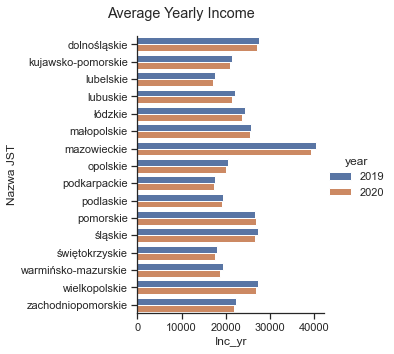

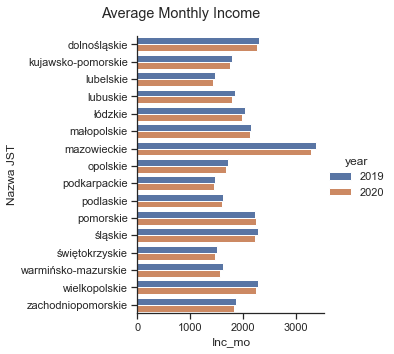

In [223]:
vis_woj(med_income)

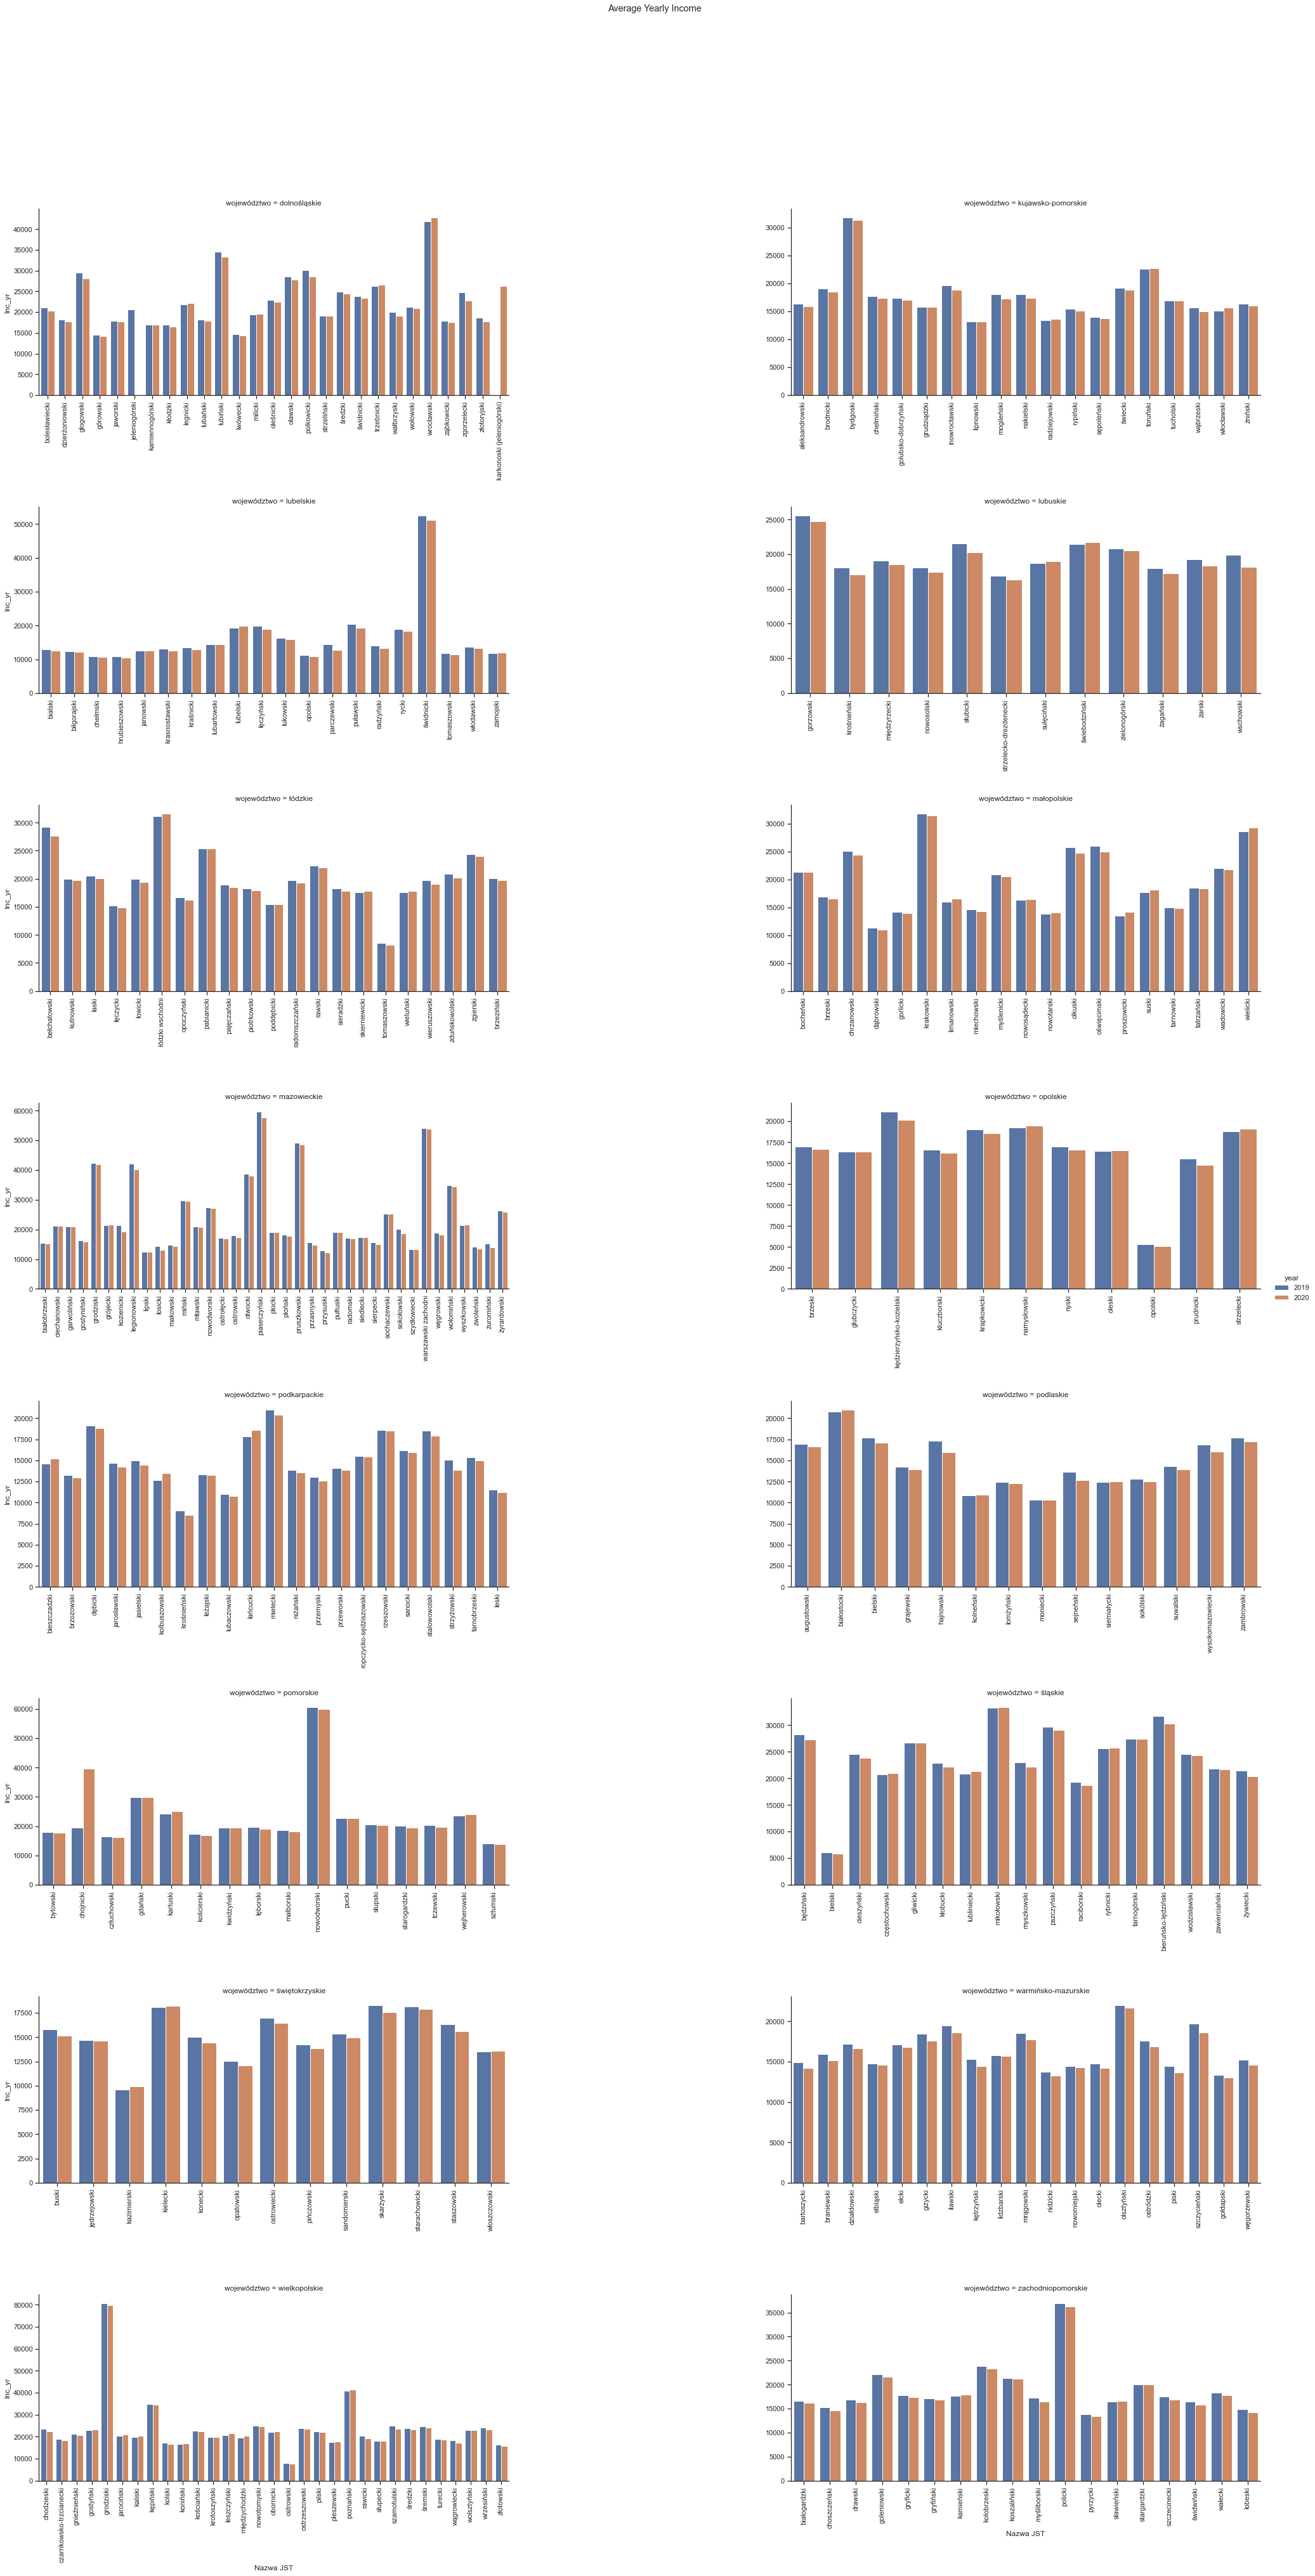

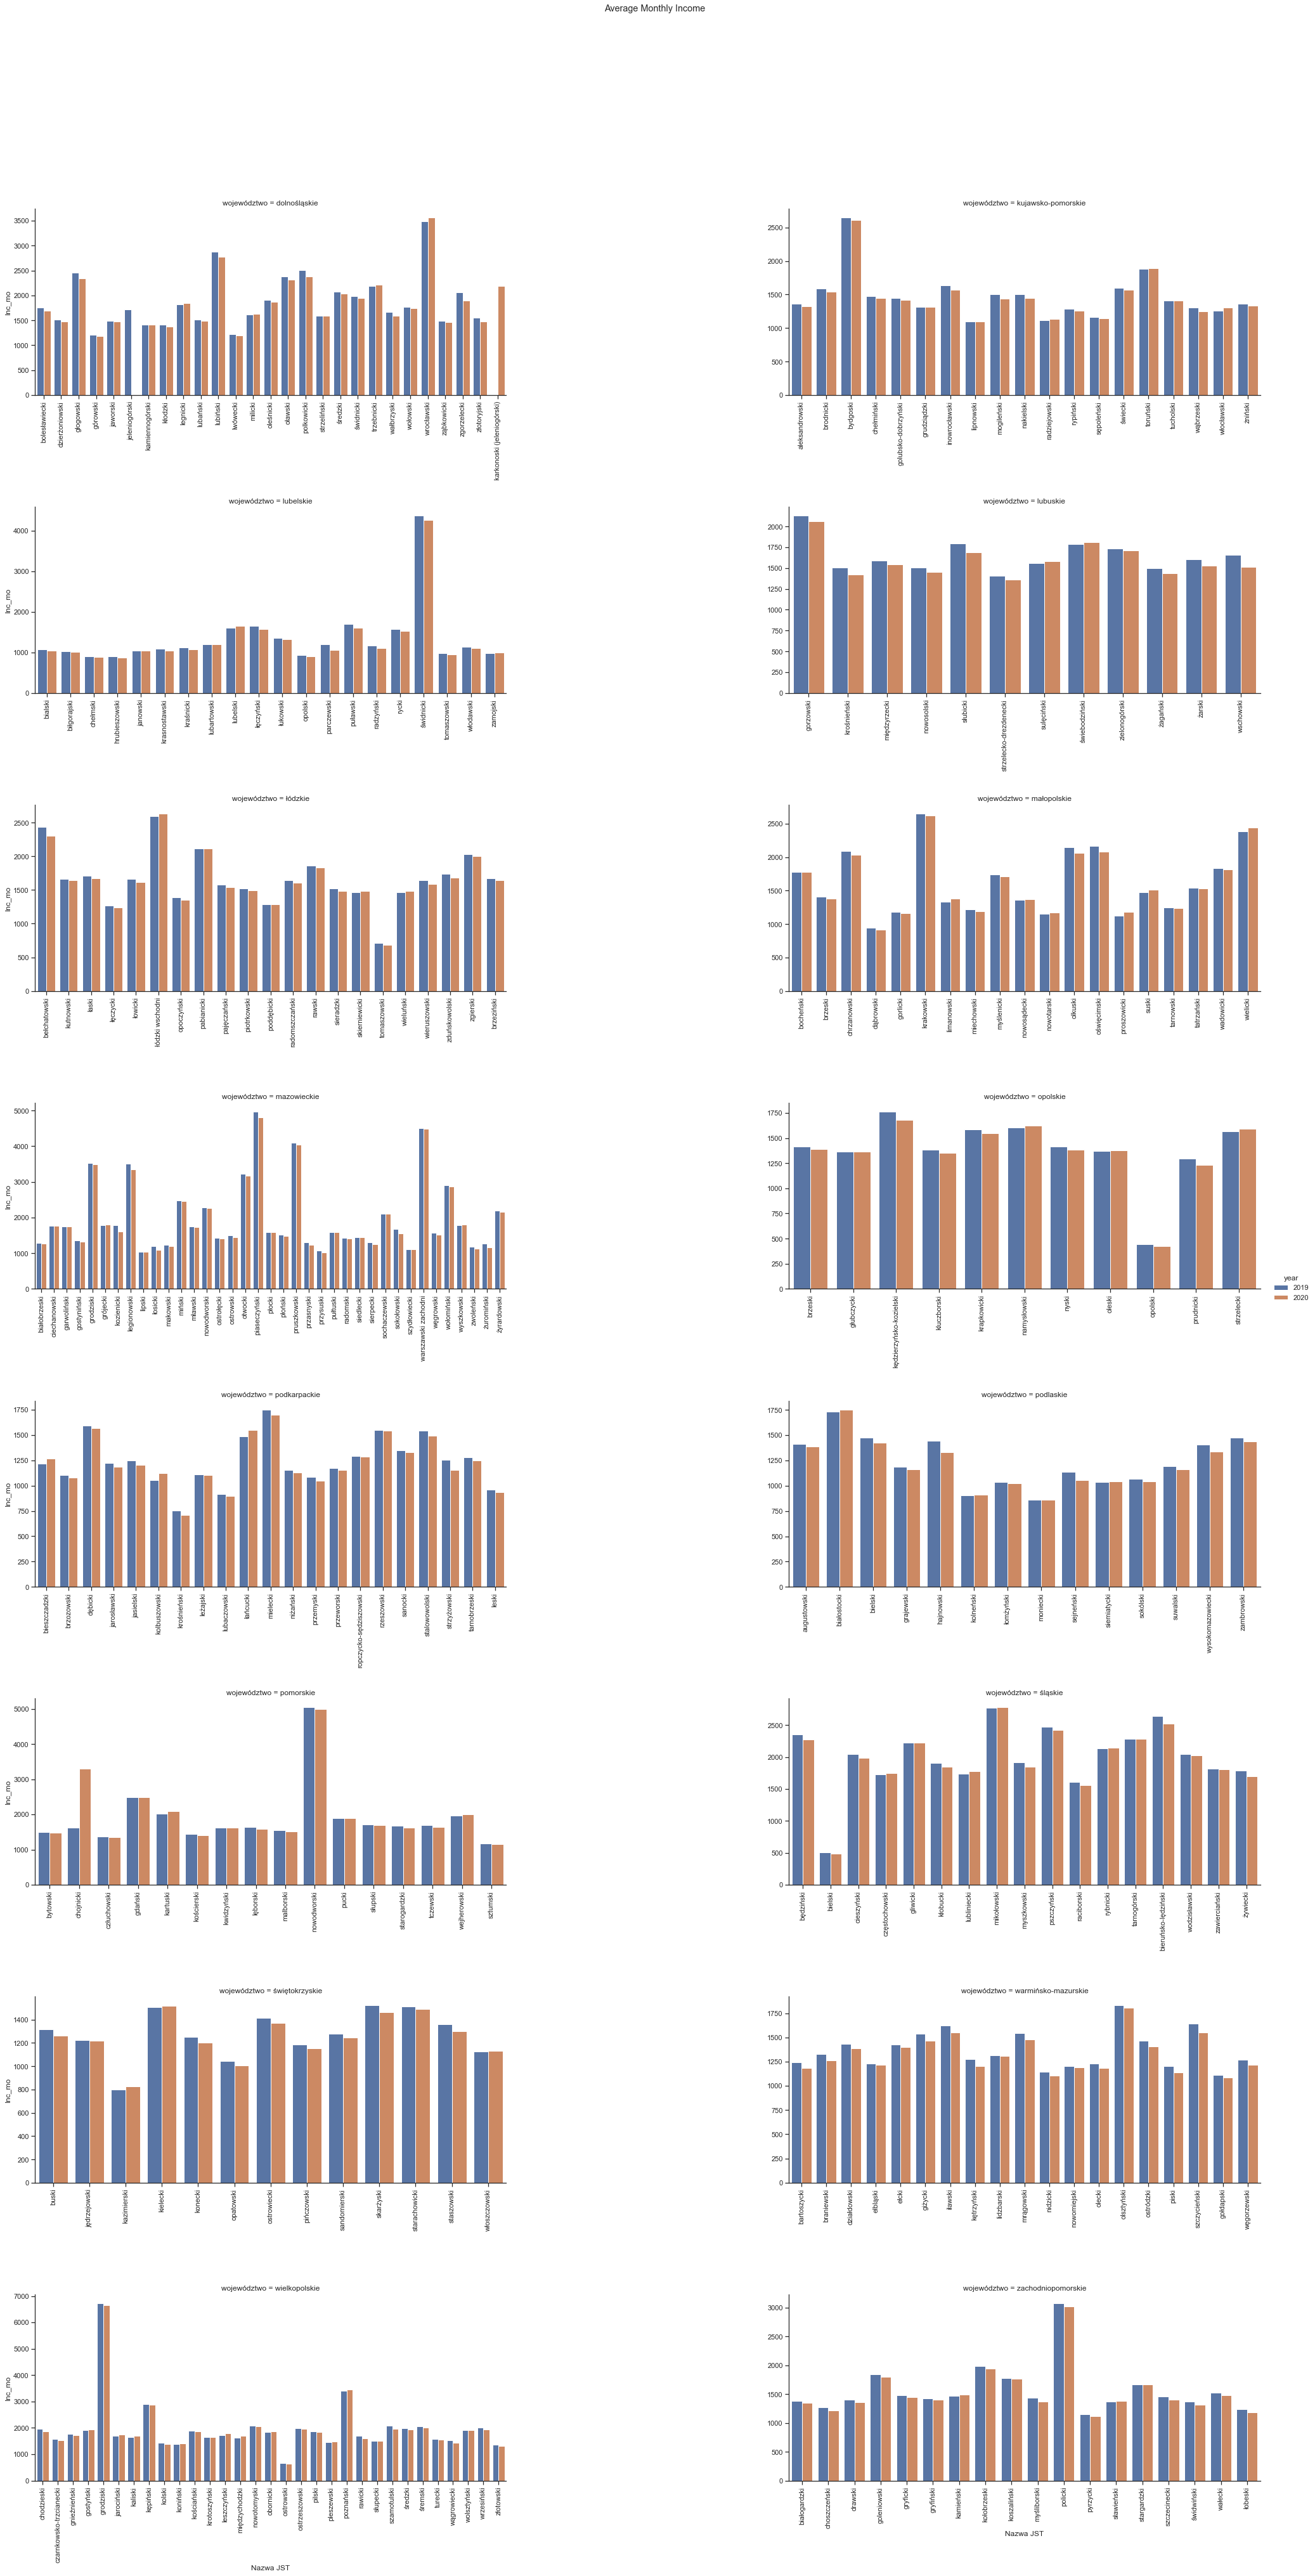

In [255]:
vis_pow(med_income)

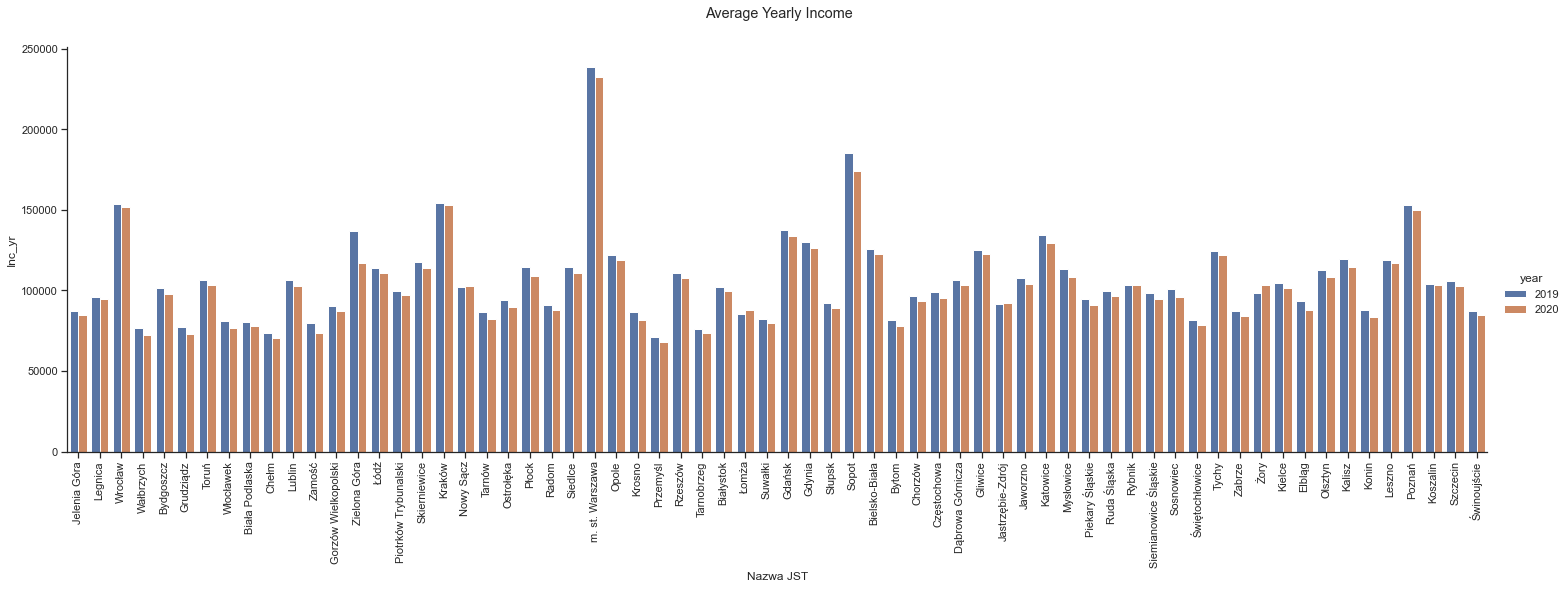

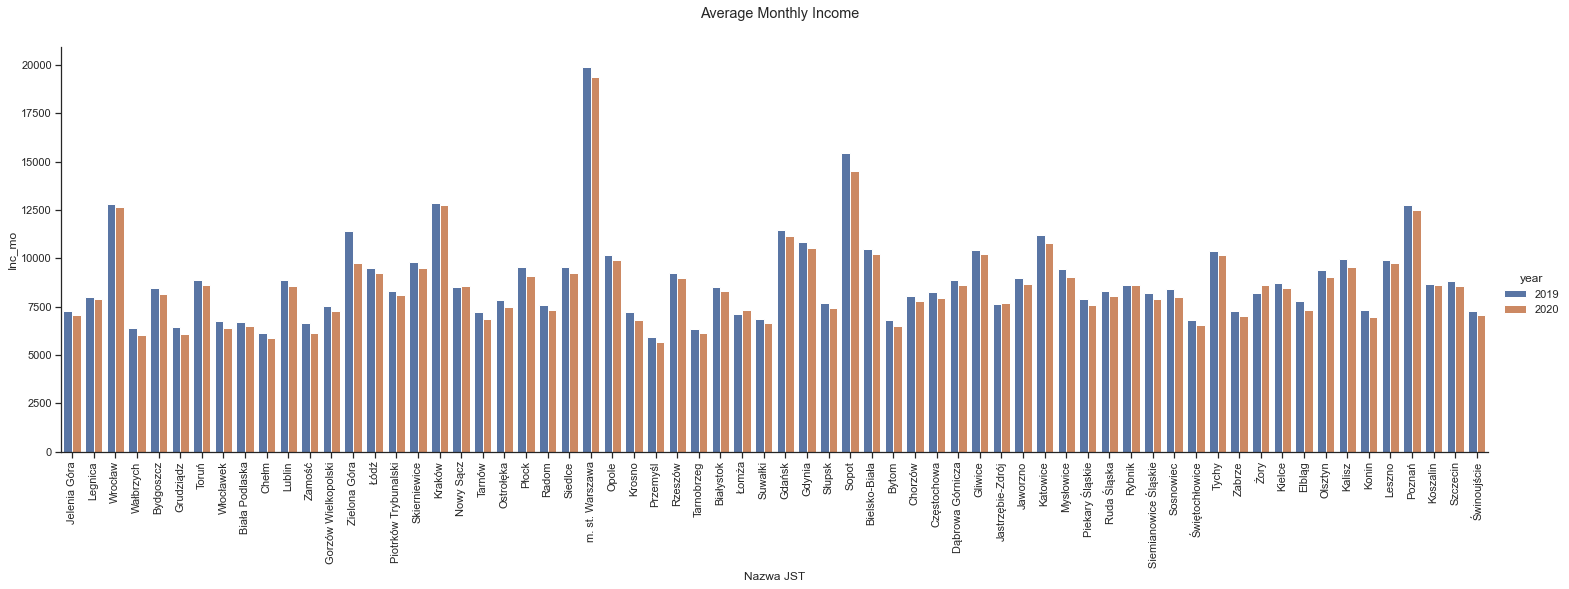

In [256]:
vis_NPP(med_income, woj_split=False)

Ta sekcja niestety jest wciąż pusta. Powyżej mamy policzone wszystkie potrzebne dane do zadania, ale zabrakło mi już czasu na ładne zrobienie modułu do wizualizacji tych danych.

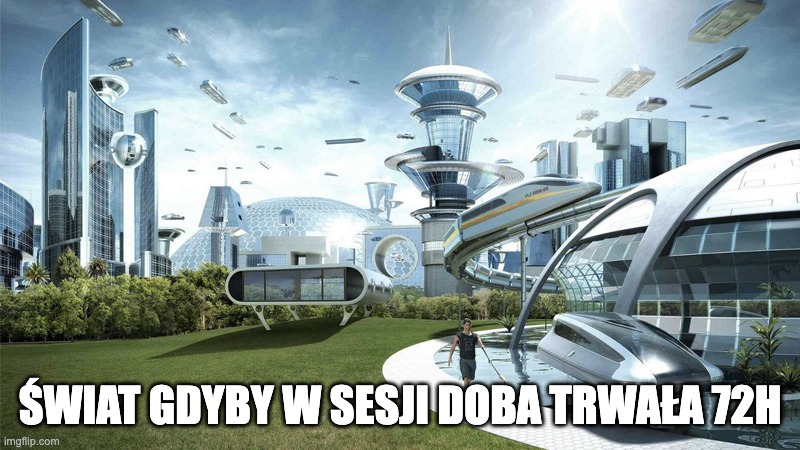

***Postaram się do prezentacji poniedziałkowej go dorobić, oraz uzupełnić dokumentajcję w texu, aby łatwiej mi było opowiadać o procesie tworzenia kodu.***

## Profiling

W tej sekcji znajdują się komórki z służace do profilowania performance'u czasowego i pamięciowego niektórych funkcji. Omówienie wyników stąd zakładam, że czeka nas w poniedziałek.

In [ ]:
# %snakeviz %mprun -f dload_to_df_list dload_to_df_list(years,verb=0)
# %snakeviz %lprun -f dload_to_df_list dload_to_df_list(years,verb=0)

In [ ]:
%snakeviz %mprun -f get_stats_gus get_stats_gus(gus_zip, verb=0, proc_working=proc_working)
%snakeviz %lprun -f get_stats_gus get_stats_gus(gus_zip, verb=0, proc_working=proc_working)

In [ ]:
%snakeviz %mprun -f get_med_income_woj get_med_income_woj(df_dict, stats_out)
%snakeviz %lprun -f get_med_income_woj get_med_income_woj(df_dict, stats_out)

In [ ]:
%snakeviz %lprun -f get_med_income_gminy get_med_income_gminy(df_dict, stats_out)
%snakeviz %mprun -f get_med_income_gminy get_med_income_gminy(df_dict, stats_out)

In [ ]:
%snakeviz %lprun -f get_med_income get_med_income(df_dict, stats_out, years)
%snakeviz %mprun -f get_med_income get_med_income(df_dict, stats_out, years)

Jak widać program na pewno można by było jeszcze zoptymalizować pamięciowo - jest to jakaś perspektywa na przyszłość

## Pre - commit

**Tutaj możemy z poziomu notebooka uruchomić wszystkie dostępne testy.**  
*Dev note: * Testy do brakujących funkcji zostaną dopisane do poniedziałkowego omównienia

In [10]:
!pytest -vv --disable-warnings

============================= test session starts ==============================
platform darwin -- Python 3.9.7, pytest-7.0.0, pluggy-1.0.0 -- /Users/k4cp3rskiii/miniforge3/bin/python
cachedir: .pytest_cache
rootdir: /Users/k4cp3rskiii/Library/Mobile Documents/com~apple~CloudDocs/MISMaP/NPD_Final/NPD_final
plugins: anyio-3.5.0
collected 9 items                                                              

taxes/tests/test_download.py::test_get_sheet_links_names[2019-res0] PASSED [ 11%]
taxes/tests/test_download.py::test_get_sheet_links_names[2020-res1] PASSED [ 22%]
taxes/tests/test_download.py::test_download_sheet_series[2019-data0-5] PASSED [ 33%]
taxes/tests/test_download.py::test_download_sheet_series[2020-data1-5] PASSED [ 44%]
taxes/tests/test_download.py::test_get_gus_stats PASSED                  [ 55%]
taxes/tests/test_loading.py::test_get_gov_dir[years0] PASSED             [ 66%]
taxes/tests/test_loading.py::test_gov_dir_to_names_dict PASSED           [ 77%]
taxes/tests/tes

Tutaj z kolei można uruchomić sprawdzenie jakości kodu, wraz z lintingiem. Jest to też zaimplementowane jako pre-commit hook do gita, ale nigdy nie zaszkodzi więcej weryfikacji :)

In [258]:
!pre-commit run --all --show-diff-on-failure

black....................................................................Passed
flake8...................................................................Passed
Check JSON...........................................(no files to check)Skipped
Check Yaml...............................................................Passed
Check for merge conflicts................................................Passed
Fix End of Files.........................................................Passed
Trim Trailing Whitespace.................................................Passed
Debug Statements (Python)................................................Passed
Mixed line ending........................................................Passed
setup-cfg-fmt............................................................Passed
pyupgrade................................................................Passed
rst ``code`` is two backticks........................(no files to check)Skipped
isort...................................